In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyubx2 import UBXReader
import matplotlib.pyplot as plt

def plot_skyplot(epochs_data):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='polar')

    ax.set_theta_zero_location('N')     # 0° ở hướng Bắc
    ax.set_theta_direction(-1)          # Đỉnh kim đồng hồ giảm góc
    ax.set_rmax(90)
    ax.set_rticks([0, 30, 60, 90])
    ax.set_rlabel_position(135)
    ax.grid(True)

    for epoch in epochs_data:
        azi = np.deg2rad(epoch['azimuth'])
        el = epoch['elevation']
        r = 90 - el  # chuyển elevation sang radius: 0° ở ngoài, 90° ở tâm
        svid = epoch['svid']

        ax.scatter(azi, r, label=svid)
        ax.text(azi, r, str(svid), ha='center', va='center')

    # plt.title("Skyplot GPS Satellites")
    plt.show()


# ---------- Classes ----------
class UBXData:
    def __init__(self):

        self.navClocks = []
        self.navPvts = []
        self.rxmRaws = []
        self.navSats = []

class RAWXData:
    def __init__(self, parsed_data):

        self.rcvTow = parsed_data.rcvTow
        self.week = parsed_data.week
        self.leapS = parsed_data.leapS
        self.numMeas = parsed_data.numMeas
        self.satData = []
        for i in range(1, parsed_data.numMeas + 1):
            self.satData.append(SatelliteData(parsed_data, i))

class SatelliteData:
    def __init__(self, parsed_data, i):
        self.prMes = getattr(parsed_data, f'prMes_{i:02}', None)
        self.cpMes = getattr(parsed_data, f'cpMes_{i:02}', None)
        self.doMes = getattr(parsed_data, f'doMes_{i:02}', None)
        self.gnssId = getattr(parsed_data, f'gnssId_{i:02}', None)
        self.svId = getattr(parsed_data, f'svId_{i:02}', None)
        self.sigId = getattr(parsed_data, f'sigId_{i:02}', None)
        self.freqId = getattr(parsed_data, f'freqId_{i:02}', None)
        self.locktime = getattr(parsed_data, f'locktime_{i:02}', None)
        self.cno = getattr(parsed_data, f'cno_{i:02}', None)
        self.prStdev = getattr(parsed_data, f'prStd_{i:02}', None)
        self.cpStdev = getattr(parsed_data, f'cpStd_{i:02}', None)
        self.doStdev = getattr(parsed_data, f'doStd_{i:02}', None)
        self.trkStat = getattr(parsed_data, f'trkStat_{i:02}', None)

# ---------- Helper Functions ----------
def calc_pseudorange(rxmRaw, navPvt):
    speed_of_light = 299792458
    ps = np.zeros(32)
    bias = np.zeros(32)
    for sat in rxmRaw.satData:
        if sat.gnssId == 0 and sat.sigId == 0:  # Only GPS L1
            ps[sat.svId - 1] = sat.cpMes + float(navPvt.nano) * 1e-9 * float(sat.doMes)
    return ps, bias

def read_ubx_file(file_path):
    rawDatas = UBXData()
    if not os.path.exists(file_path):
        print(f"Error: File not found - {file_path}")
        return rawDatas

    with open(file_path, 'rb') as file:
        ubr = UBXReader(file, protfilter=2)
        for raw_data, parsed_data in ubr:
            if parsed_data.identity == "RXM-RAWX":
                rawDatas.rxmRaws.append(RAWXData(parsed_data))
            elif parsed_data.identity == "NAV-CLOCK":
                rawDatas.navClocks.append(parsed_data)
            elif parsed_data.identity == "NAV-PVT":
                rawDatas.navPvts.append(parsed_data)
            elif parsed_data.identity == "NAV-SAT":
                rawDatas.navSats.append(parsed_data)

    return rawDatas

# ---------- Synchronize TOW ----------
def sync_by_tow(data1, data2):
    offset = int(float(data1.rxmRaws[0].rcvTow) - float(data2.rxmRaws[0].rcvTow))

    if offset > 0:
        data2.navPvts = data2.navPvts[offset:]
        data2.navClocks = data2.navClocks[offset:]
        data2.rxmRaws = data2.rxmRaws[offset:]
    elif offset < 0:
        offset = abs(offset)
        data1.navPvts = data1.navPvts[offset:]
        data1.navClocks = data1.navClocks[offset:]
        data1.rxmRaws = data1.rxmRaws[offset:]
    return data1, data2


def compute_dps(rawData1, rawData2, startIndex=0, dataLength=150):
    dps = np.zeros((dataLength, 32))
    svId_to_idx = {}
    idx_to_svId = {}
    sv_counter = 0

    for idx in range(dataLength):
        data_idx = startIndex + idx
        if data_idx >= len(rawData1.rxmRaws) or data_idx >= len(rawData2.rxmRaws):
            break

        satData1 = rawData1.rxmRaws[data_idx]
        navPvt1 = rawData1.navPvts[data_idx]
        ps1, bs1 = calc_pseudorange(satData1, navPvt1)

        satData2 = rawData2.rxmRaws[data_idx]
        navPvt2 = rawData2.navPvts[data_idx]
        ps2, bs2 = calc_pseudorange(satData2, navPvt2)

        ps1 += bs1
        ps2 += bs2

        for i in range(32):
            if ps1[i] != 0 and ps2[i] != 0:
                svId = i + 1
                if svId not in svId_to_idx:
                    svId_to_idx[svId] = sv_counter
                    idx_to_svId[sv_counter] = svId
                    sv_counter += 1
                dps[idx, svId_to_idx[svId]] = (ps1[i] - ps2[i])

        if sv_counter > 0:
            dps[idx, :] -= dps[idx, 0]
            dps[idx, :] -= np.round(dps[idx, :])

    valid_columns = np.any(dps != 0, axis=0)
    dps_trimmed = dps[:, valid_columns]

    svIds = []
    for i, valid in enumerate(valid_columns):
        if valid:
            for svId, idx in svId_to_idx.items():
                if idx == i:
                    svIds.append(svId)
                    break
    return dps_trimmed, svIds


In [2]:
##### ---------- File Paths ----------
base_dir = os.getcwd()

file1 = os.path.join(base_dir, "2025-08-05", "raw_data_1.ubx")
file2 = os.path.join(base_dir, "2025-08-05", "raw_data_2.ubx")

# ---------- File Paths ----------
base_dir = os.getcwd()

# Spoofing data files
spoofing_file_1 = os.path.join(base_dir, "SpoofingData/SP-2025-04-24_11", "raw_data_1.ubx")
spoofing_file_2 = os.path.join(base_dir, "SpoofingData/SP-2025-04-24_11", "raw_data_2.ubx")

normal_file_1 = os.path.join(base_dir, "2025-08-05", "raw_data_1.ubx")
normal_file_2 = os.path.join(base_dir, "2025-08-05", "raw_data_2.ubx")

# ---------- Read UBX Files ----------
print(f"Reading normal files:\n - {normal_file_1}\n - {normal_file_2}")
normal_data_1 = read_ubx_file(normal_file_1)
normal_data_2 = read_ubx_file(normal_file_2)

print(f"Reading spoofing files:\n - {spoofing_file_1}\n - {spoofing_file_2}")
spoofing_data_1 = read_ubx_file(spoofing_file_1)
spoofing_data_2 = read_ubx_file(spoofing_file_2)

# Sync spoofing data
spoofing_data_1, spoofing_data_2 = sync_by_tow(spoofing_data_1, spoofing_data_2)

# Sync normal data
normal_data_1, normal_data_2 = sync_by_tow(normal_data_1, normal_data_2)

Reading normal files:
 - /Users/ngocmx/PycharmProjects/measurement/2025-08-05/raw_data_1.ubx
 - /Users/ngocmx/PycharmProjects/measurement/2025-08-05/raw_data_2.ubx
Reading spoofing files:
 - /Users/ngocmx/PycharmProjects/measurement/SpoofingData/SP-2025-04-24_11/raw_data_1.ubx
 - /Users/ngocmx/PycharmProjects/measurement/SpoofingData/SP-2025-04-24_11/raw_data_2.ubx


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


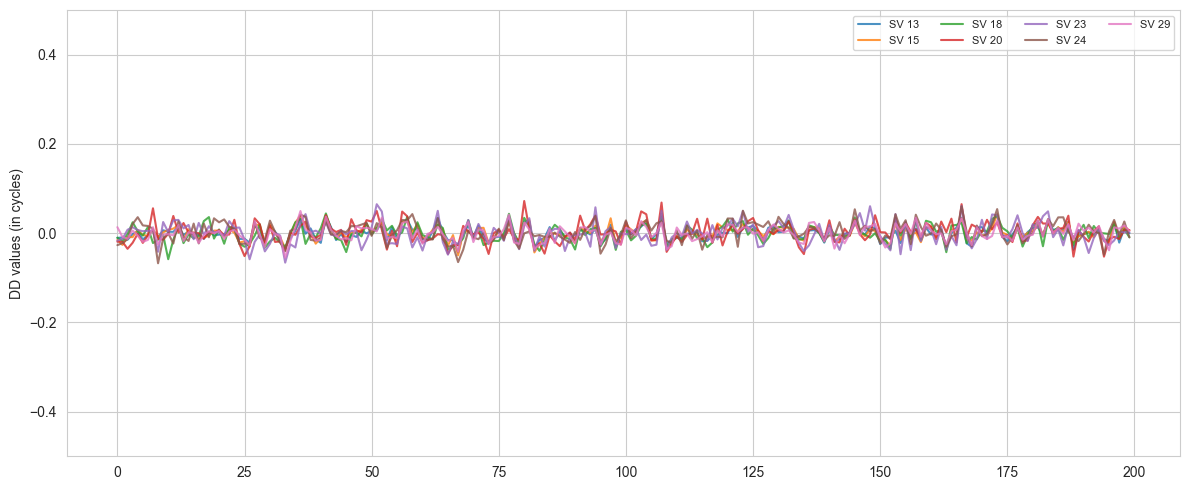

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


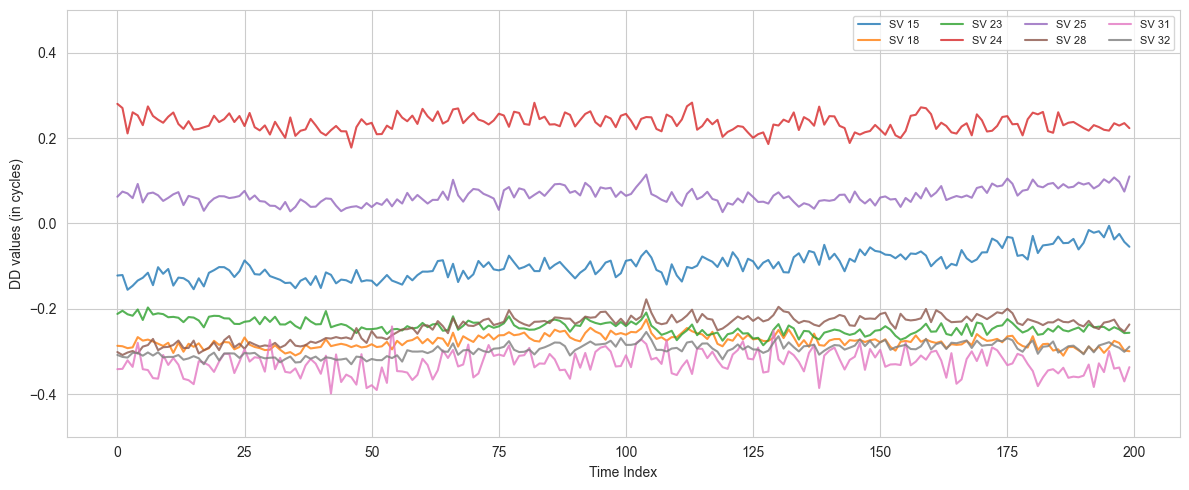

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


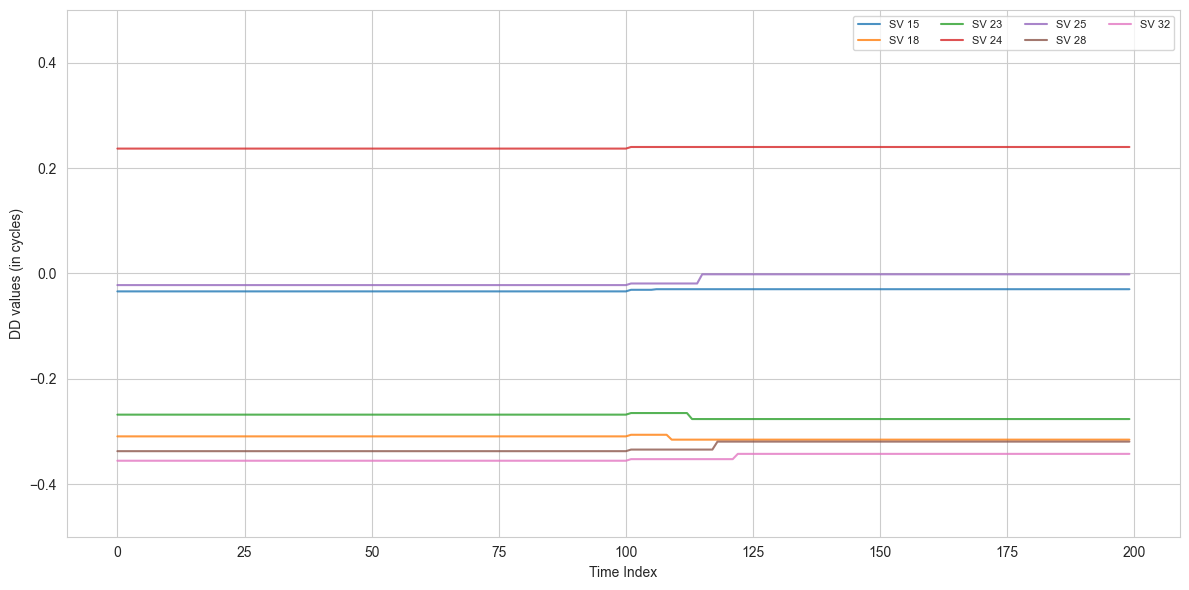

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


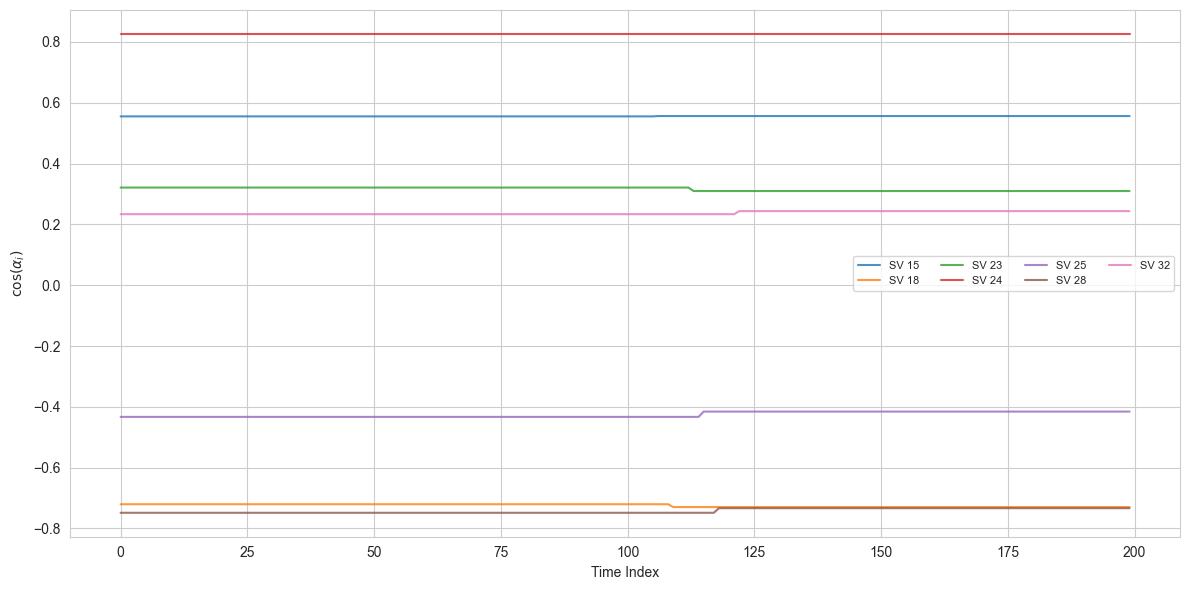

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


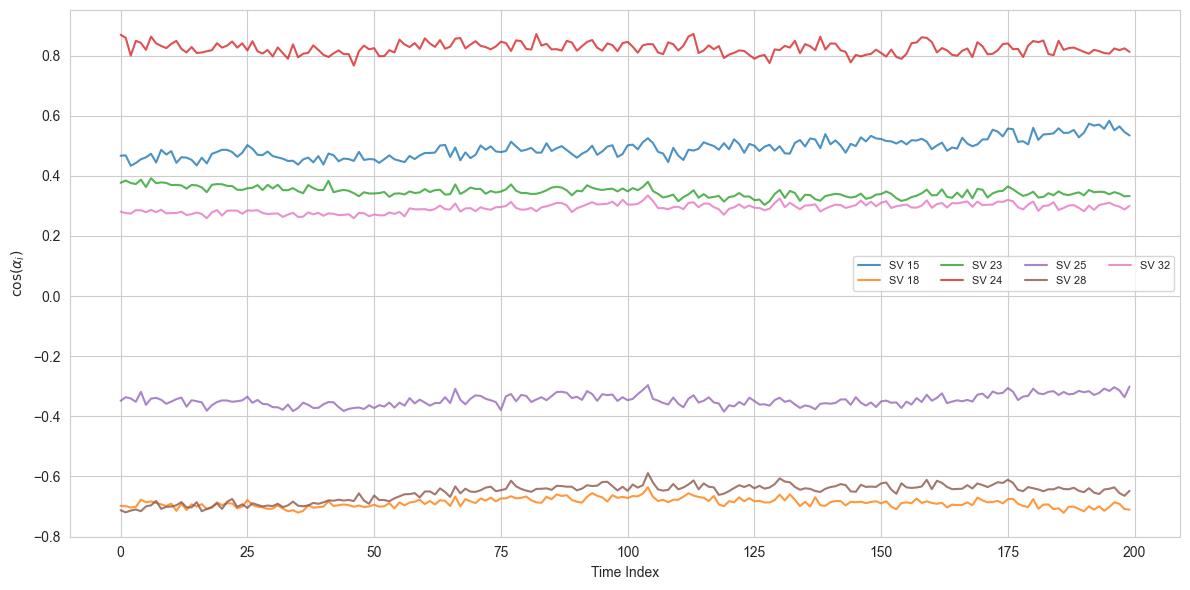

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


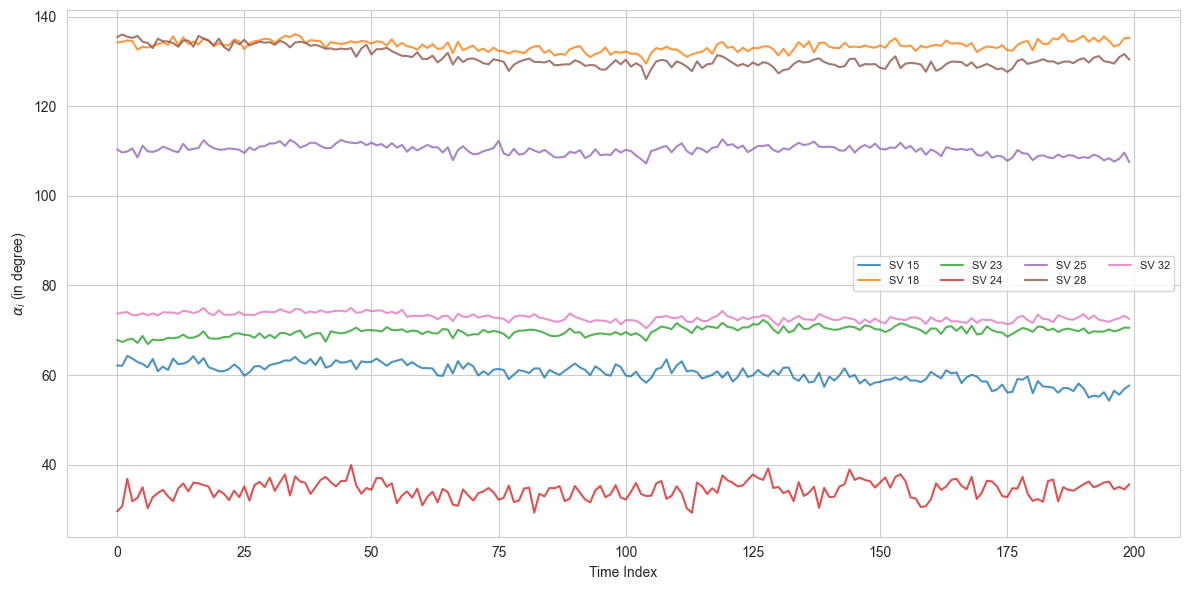

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


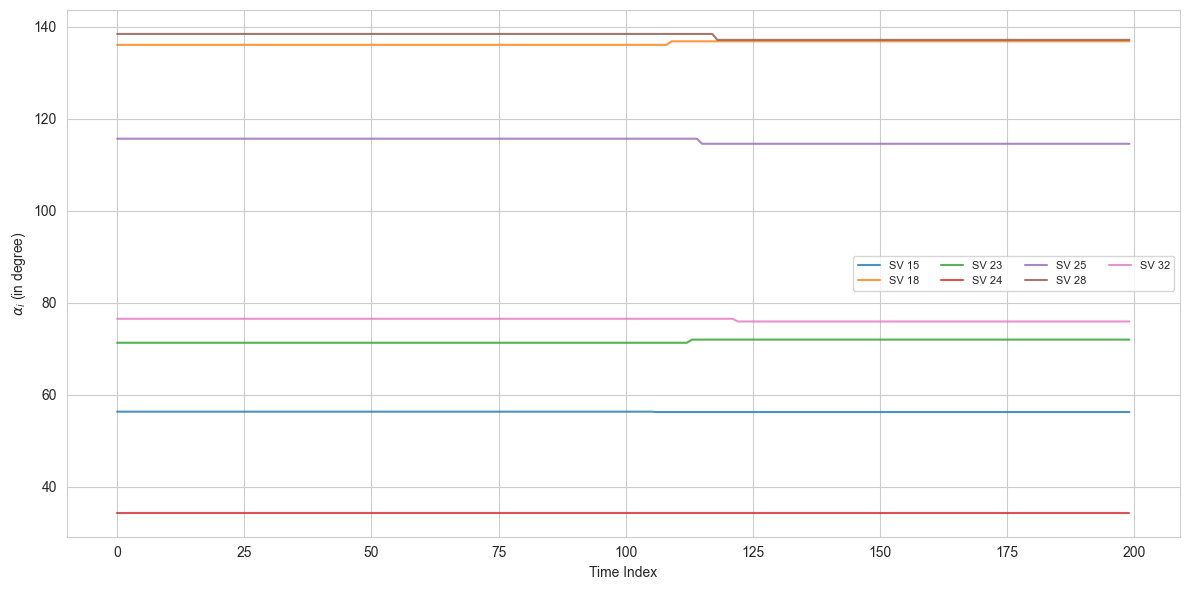

In [5]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# ================== PARAMETER ==================
start_index = 4000
length = 200
alpha_r_deg = 53.89629
bias_angle = 16
selected_svids = [15, 18, 23, 24, 25, 28, 32]

# ================== HÀM TÍNH ==================
def psi_i_deg(alpha_r_deg,alpha_i_deg):
    alpha_i_rad = math.radians(alpha_i_deg)
    alpha_r_rad = math.radians(alpha_r_deg)
    diff = math.cos(alpha_i_rad) - math.cos(alpha_r_rad)
    return diff - round(diff)

def alpha_i_from_psi(psi_values, alpha_r_deg):
    cos_alpha_r = math.cos(math.radians(alpha_r_deg))
    alpha_i_list = []
    for psi in psi_values:
        val = psi + cos_alpha_r
        val = max(min(val, 1.0), -1.0)  # tránh lỗi domain
        alpha_i_list.append(math.degrees(math.acos(val)))
    return alpha_i_list

# ================== HÀM LƯU ==================
def save_fig(fig, filename, output_dir):
    for ext in ["png", "pdf", "eps"]:
        fig.savefig(os.path.join(output_dir, f"{filename}.{ext}"), format=ext, dpi=300)

# ================== DPS ==================
spoof_dps, spoof_svIds = compute_dps(spoofing_data_1, spoofing_data_2, dataLength=length)
normal_dps, normal_svIds = compute_dps(normal_data_1, normal_data_2, startIndex=start_index, dataLength=length )

folder_name = os.path.basename(os.path.dirname(file1))
output_dir = os.path.join("Plot", "AOA", f"Spoofing_Results_{length}s")
os.makedirs(output_dir, exist_ok=True)

# ---- Figure Spoofing DD ----
fig1, ax1 = plt.subplots(figsize=(12, 5))
for i, svId in enumerate(spoof_svIds):
    if svId not in [1, 3, 30, 12]:
        ax1.plot(spoof_dps[:, i], label=f'SV {svId}', linestyle='-', alpha=0.8)
# # ax1.set_title('Double-Difference Carrier Phase Measurements - Spoofing Scenario')
ax1.set_ylabel('DD values (in cycles)')
ax1.set_ylim([-0.5, 0.5])
ax1.legend(ncol=4, fontsize=8)
ax1.grid(True)
plt.tight_layout()
save_fig(fig1, "dd_spoofing", output_dir)
plt.show()

# ---- Figure Normal DD ----
fig2, ax2 = plt.subplots(figsize=(12, 5))
for i, svId in enumerate(normal_svIds):
    if svId not in [12]:
        ax2.plot(normal_dps[:, i], label=f'SV {svId}', linestyle='-', alpha=0.8)
# # ax2.set_title('Double-Difference Carrier Phase Measurements - Normal Scenario')
ax2.set_xlabel('Time Index')
ax2.set_ylabel('DD values (in cycles)')
ax2.set_ylim([-0.5, 0.5])
ax2.legend(ncol=4, fontsize=8)
ax2.grid(True)
plt.tight_layout()
save_fig(fig2, "dd_normal", output_dir)
plt.show()

# ================== PSI & AOA ==================
psi_timeseries = {}
value_deg_timeseries = {}

for epoch_idx, msg in enumerate(
    normal_data_1.navSats[start_index:start_index + length],
    start=start_index
):
    gps_sats = []
    for i in range(1, msg.numSvs + 1):
        gnss = getattr(msg, f"gnssId_{i:02d}")
        if gnss == 0:  # GPS
            svid = getattr(msg, f"svId_{i:02d}")
            elev = getattr(msg, f"elev_{i:02d}")
            azim = getattr(msg, f"azim_{i:02d}")
            elev_rad = math.radians(elev)
            azim_rad = math.radians(azim - bias_angle)
            cos_val = math.cos(elev_rad) * math.cos(azim_rad)
            value_deg = math.degrees(math.acos(cos_val))
            gps_sats.append((svid, value_deg))

    if gps_sats:
        alpha_r_val_deg = gps_sats[0][1]
        for svid, alpha_i_val_deg in gps_sats:
            psi_val = psi_i_deg(alpha_r_val_deg, alpha_i_val_deg)
            psi_timeseries.setdefault(svid, []).append(psi_val)
            value_deg_timeseries.setdefault(svid, []).append(alpha_i_val_deg)

epochs = range(length)
epochs_arr = np.arange(length).reshape(-1, 1)

# ---- Figure Psi_i ----
fig3 = plt.figure(figsize=(12, 6))
for svid, psi_list in psi_timeseries.items():
    if svid in selected_svids:
        plt.plot(epochs, psi_list, label=f"SV {svid}", linestyle='-', alpha=0.8)
plt.ylim([-0.5, 0.5])
plt.ylabel("DD values (in cycles)")
plt.xlabel("Time Index")
# plt.title("Reverse Double Difference Measurements")
plt.legend(ncol=4, fontsize=8)
plt.grid(True)
plt.tight_layout()
save_fig(fig3, "reverse_dd", output_dir)
plt.show()

# ---- Figure cos_alpha_i (from value_deg) ----
fig4 = plt.figure(figsize=(12, 6))
for svid, val_list in value_deg_timeseries.items():
    if svid in selected_svids:
        # chuyển độ -> radian, rồi lấy cos
        cos_vals = np.cos(np.radians(val_list))
        plt.plot(epochs, cos_vals, label=f"SV {svid}", linestyle='-', alpha=0.8)

plt.ylabel(r"$\cos(\alpha_i)$")
plt.xlabel("Time Index")
# plt.title(r"$\cos(\alpha_i)$ calculated from ephemeris")
plt.legend(ncol=4, fontsize=8)
plt.grid(True)
plt.tight_layout()
save_fig(fig4, "cos_alpha_i_from_ephemeris", output_dir)
plt.show()

# ---- Figure cos_alpha_i (DD) ----
fig7 = plt.figure(figsize=(12, 6))
cos_alpha_r = math.cos(math.radians(alpha_r_deg))
for i, svid in enumerate(normal_svIds):
    if svid in selected_svids:
        psi_dd = normal_dps[:, i]  # dữ liệu psi từ DD
        if svid in [15, 23, 24, 32]:
            y_pred = psi_dd + cos_alpha_r
        if svid in [18, 25, 28]:
            y_pred = psi_dd + cos_alpha_r -1
        plt.plot(np.arange(length), y_pred, label=f"SV {svid}", linestyle='-', alpha=0.8)
# plt.title(r"$\cos(\alpha_i) = \psi + \cos(\alpha_r)$ (from normal_dps)")
plt.ylabel(r"$\cos(\alpha_i)$")
plt.xlabel("Time Index")
plt.legend(ncol=4, fontsize=8)
plt.grid(True)
plt.tight_layout()
save_fig(fig7, "cos_alpha_i_from_dd", output_dir)
plt.show()

# ---- Figure alpha_i (DD) = arccos(cos_alpha_i) ----
fig8 = plt.figure(figsize=(12, 6))
for i, svid in enumerate(normal_svIds):
    if svid in selected_svids:
        psi_dd = normal_dps[:, i]
        if svid in [15, 23, 24, 32]:
            y_pred = psi_dd + cos_alpha_r
        if svid in [18, 25, 28]:
            y_pred = psi_dd + cos_alpha_r - 1

        # arccos -> radian -> degree
        y_alpha_deg = np.degrees(np.arccos(np.clip(y_pred, -1, 1)))
        plt.plot(np.arange(length), y_alpha_deg, label=f"SV {svid}", linestyle='-', alpha=0.8)

plt.ylabel(r"$\alpha_i$ (in degree)")
plt.xlabel("Time Index")
plt.legend(ncol=4, fontsize=8)
plt.grid(True)
plt.tight_layout()
save_fig(fig8, "aoa_from_dd", output_dir)
plt.show()

# ---- Figure Value_deg ----
fig4 = plt.figure(figsize=(12, 6))
for svid, val_list in value_deg_timeseries.items():
    if svid in selected_svids:
        plt.plot(epochs, val_list, label=f"SV {svid}", linestyle='-', alpha=0.8)
plt.ylabel(r"$\alpha_i$ (in degree)")
plt.xlabel("Time Index")
# plt.title("AOA calculated from ephemeris")
plt.legend(ncol=4, fontsize=8)
plt.grid(True)
plt.tight_layout()
save_fig(fig4, "aoa_from_ephemeris", output_dir)
plt.show()



In [ ]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

# ================== PARAMETER ==================
start_index = 0
length = 200
alpha_r_deg = 40.83
bias_angle = 10
selected_svids = [13, 15, 18, 20, 23, 24, 29]

# ================== HÀM TÍNH ==================
def psi_i_deg(alpha_r_deg, alpha_i_deg):
    alpha_i_rad = math.radians(alpha_i_deg)
    alpha_r_rad = math.radians(alpha_r_deg)
    diff = math.cos(alpha_i_rad) - math.cos(alpha_r_rad)
    return diff - round(diff)

def alpha_i_from_psi(psi_values, alpha_r_deg):
    cos_alpha_r = math.cos(math.radians(alpha_r_deg))
    alpha_i_list = []
    for psi in psi_values:
        val = psi + cos_alpha_r
        val = max(min(val, 1.0), -1.0)  # tránh lỗi domain
        alpha_i_list.append(math.degrees(math.acos(val)))
    return alpha_i_list

# ================== HÀM LƯU ==================
def save_fig(fig, filename, output_dir):
    for ext in ["png", "pdf", "eps"]:
        fig.savefig(os.path.join(output_dir, f"{filename}.{ext}"), format=ext, dpi=300)

# ================== DPS ==================
spoof_dps, spoof_svIds = compute_dps(spoofing_data_1, spoofing_data_2, dataLength=length)

folder_name = os.path.basename(os.path.dirname(file1))
output_dir = os.path.join("Plot", "AOA", "Results_Spoofing_200s")
os.makedirs(output_dir, exist_ok=True)

# ---- Figure Spoofing DD ----
fig1, ax1 = plt.subplots(figsize=(12, 5))
for i, svId in enumerate(spoof_svIds):
    if svId not in [1, 3, 30, 12]:
        ax1.plot(spoof_dps[:, i], label=f'SV {svId}', linestyle='-', alpha=0.8)
ax1.set_ylabel('DD values (in cycles)')
ax1.set_ylim([-0.5, 0.5])
ax1.legend(ncol=4, fontsize=8)
ax1.grid(True)
plt.tight_layout()
save_fig(fig1, "dd_spoofing", output_dir)
plt.show()

# ================== PSI & AOA ==================
psi_timeseries = {}
value_deg_timeseries = {}

for epoch_idx, msg in enumerate(
    spoofing_data_1.navSats[start_index:start_index + length],
    start=start_index
):
    gps_sats = []
    for i in range(1, msg.numSvs + 1):
        gnss = getattr(msg, f"gnssId_{i:02d}")
        if gnss == 0:  # GPS
            svid = getattr(msg, f"svId_{i:02d}")
            elev = getattr(msg, f"elev_{i:02d}")
            azim = getattr(msg, f"azim_{i:02d}")
            elev_rad = math.radians(elev)
            azim_rad = math.radians(azim - bias_angle)
            cos_val = math.cos(elev_rad) * math.cos(azim_rad)
            value_deg = math.degrees(math.acos(cos_val))
            gps_sats.append((svid, value_deg))

    if gps_sats:
        alpha_r_val_deg = gps_sats[0][1]
        for svid, alpha_i_val_deg in gps_sats:
            psi_val = psi_i_deg(alpha_r_val_deg, alpha_i_val_deg)
            psi_timeseries.setdefault(svid, []).append(psi_val)
            value_deg_timeseries.setdefault(svid, []).append(alpha_i_val_deg)

epochs = np.arange(length)

# ---- Figure Psi_i ----
fig3, ax3 = plt.subplots(figsize=(12, 6))
for svid, psi_list in psi_timeseries.items():
    if svid in selected_svids:
        y = np.full(length, np.nan)   # pad with NaN
        y[:len(psi_list)] = psi_list
        ax3.plot(epochs, y, label=f"SV {svid}", linestyle='-', alpha=0.8)
ax3.set_ylim([-0.5, 0.5])
ax3.set_ylabel("DD values (in cycles)")
ax3.set_xlabel("Time Index")
ax3.legend(ncol=4, fontsize=8)
ax3.grid(True)
plt.tight_layout()
save_fig(fig3, "reverse_dd", output_dir)
plt.show()

# ---- Figure cos_alpha_i (from ephemeris) ----
fig4a, ax4a = plt.subplots(figsize=(12, 6))
for svid, val_list in value_deg_timeseries.items():
    if svid in selected_svids:
        y = np.full(length, np.nan)
        y[:len(val_list)] = np.cos(np.radians(val_list))
        ax4a.plot(epochs, y, label=f"SV {svid}", linestyle='-', alpha=0.8)
ax4a.set_ylabel(r"$\cos(\alpha_i)$")
ax4a.set_xlabel("Time Index")
ax4a.legend(ncol=4, fontsize=8)
ax4a.grid(True)
plt.tight_layout()
save_fig(fig4a, "cos_alpha_i_from_ephemeris", output_dir)
plt.show()

# ---- Figure cos_alpha_i (from DD) ----
fig7, ax7 = plt.subplots(figsize=(12, 6))
cos_alpha_r = math.cos(math.radians(alpha_r_deg))
for i, svid in enumerate(spoof_svIds):
    if svid in selected_svids:
        psi_dd = spoof_dps[:, i]
        y_pred = psi_dd + cos_alpha_r
        # if svid in [15, 23, 24, 32]:
        #     y_pred = psi_dd + cos_alpha_r
        # if svid in [24]:
        #     y_pred = psi_dd + cos_alpha_r -1
        # else:
        #     y_pred = psi_dd + cos_alpha_r
        ax7.plot(epochs, y_pred, label=f"SV {svid}", linestyle='-', alpha=0.8)
ax7.set_ylim([-1, 1])
ax7.set_ylabel(r"$\cos(\alpha_i)$")
ax7.set_xlabel("Time Index")
ax7.legend(ncol=4, fontsize=8)
ax7.grid(True)
plt.tight_layout()
save_fig(fig7, "cos_alpha_i_from_dd", output_dir)
plt.show()

# ---- Figure alpha_i (from DD) ----
fig8, ax8 = plt.subplots(figsize=(12, 6))
for i, svid in enumerate(spoof_svIds):
    if svid in selected_svids:
        psi_dd = spoof_dps[:, i]
        y_pred = psi_dd + cos_alpha_r
        y_alpha_deg = np.degrees(np.arccos(np.clip(y_pred, -1, 1)))
        ax8.plot(epochs, y_alpha_deg, label=f"SV {svid}", linestyle='-', alpha=0.8)
ax8.set_ylim([0,180])
ax8.set_ylabel(r"$\alpha_i$ (in degree)")
ax8.set_xlabel("Time Index")
ax8.legend(ncol=4, fontsize=8)
ax8.grid(True)
plt.tight_layout()
save_fig(fig8, "aoa_from_dd", output_dir)
plt.show()

# ---- Figure alpha_i (from ephemeris) ----
fig9, ax9 = plt.subplots(figsize=(12, 6))
for svid, val_list in value_deg_timeseries.items():
    if svid in selected_svids:
        y = np.full(length, np.nan)
        y[:len(val_list)] = val_list
        ax9.plot(epochs, y, label=f"SV {svid}", linestyle='-', alpha=0.8)
ax9.set_ylim([0, 180])
ax9.set_ylabel(r"$\alpha_i$ (in degree)")
ax9.set_xlabel("Time Index")
ax9.legend(ncol=4, fontsize=8)
ax9.grid(True)
plt.tight_layout()
save_fig(fig9, "aoa_from_ephemeris", output_dir)
plt.show()


In [ ]:
# ===== Chuẩn bị dữ liệu chuẩn (Ephemeris) =====
eph_data = {}  # {svid: np.array([...])}
for svid, val_list in value_deg_timeseries.items():
    if svid in selected_svids:
        eph_data[svid] = np.array(val_list[:length])  # đã là degree

# ===== Dữ liệu từ DD =====
dd_data = {}  # {svid: np.array([...])}
for i, svid in enumerate(normal_svIds):
    if svid in selected_svids:
        psi_dd = normal_dps[:, i]
        if svid in [15, 23, 24, 32]:
            y_pred = psi_dd + cos_alpha_r
        if svid in [18, 25, 28]:
            y_pred = psi_dd + cos_alpha_r - 1
        # arccos -> degree
        y_alpha_deg = np.degrees(np.arccos(np.clip(y_pred, -1, 1)))
        dd_data[svid] = y_alpha_deg[:length]

# ===== So sánh DD vs Ephemeris =====
def compare_dd_vs_eph(eph_data, dd_data, thresholds=(5, 7, 10)):  # thresholds tính bằng degree
    rows = []
    common_svids = set(eph_data.keys()) & set(dd_data.keys())  # giao các SV có đủ dữ liệu

    for thr in thresholds:
        for svid in sorted(common_svids):
            eph = eph_data[svid]
            dd  = dd_data[svid]

            # đảm bảo cùng chiều dài
            n = min(len(eph), len(dd))
            eph = eph[:n]
            dd  = dd[:n]

            abs_err = np.abs(dd - eph)
            bins_ok = np.sum(abs_err <= thr)
            bins_total = n
            frac_ok = bins_ok / bins_total if bins_total > 0 else np.nan

            # Rule: với ngưỡng 10° phải > 75%
            rule = ""
            if thr == 10:
                rule = "OK" if frac_ok > 0.75 else "NOT OK"

            rows.append({
                "SV": svid,
                "threshold": f"{thr} deg",
                "bins_ok": bins_ok,
                "bins_total": bins_total,
                "fraction_ok": round(frac_ok, 3),
                "rule_5deg": rule
            })

        # Tổng hợp tất cả SV
        eph_all = np.concatenate([eph_data[s][:n] for s in common_svids])
        dd_all  = np.concatenate([dd_data[s][:n] for s in common_svids])

        abs_err_all = np.abs(dd_all - eph_all)
        bins_ok_all = np.sum(abs_err_all <= thr)
        bins_total_all = len(eph_all)
        frac_ok_all = bins_ok_all / bins_total_all if bins_total_all > 0 else np.nan

        rule_all = ""
        if thr == 10:
            rule_all = "OK" if frac_ok_all > 0.75 else "NOT OK"

        rows.append({
            "SV": "ALL",
            "threshold": f"{thr} deg",
            "bins_ok": bins_ok_all,
            "bins_total": bins_total_all,
            "fraction_ok": round(frac_ok_all, 3),
            "rule_5deg": rule_all
        })
    return pd.DataFrame(rows)

# Gọi hàm
df_compare = compare_dd_vs_eph(eph_data, dd_data)
print(df_compare)

# Xuất Excel
output_file = "compare_dd_vs_ephemeris_deg.xlsx"
df_compare.to_excel(output_file, index=False)
print(f"Đã lưu kết quả ra file: {output_file}")

